<a href="https://colab.research.google.com/github/valeriu-balaban/fair-ml-presentation/blob/main/Fair_ML_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Fair ML Models

 - Fairness will play a major role in automated systems such as ML
 - For now we do not always have many answers, just a lot of questions
 - Let's make it interactive. Think and answer questions 
 - There is no right of wrong answer
 - Presented methods can be easily integrated in any project
 - Code is in vanila Pytorch and can be ported to Keras, Tensorflow, JAX, etc.

**Outline:**
1. When things go wrong, examples
1. Datasets description
1. Definition and fairness metrics
1. Conditional Value at Risk method (simplified)
1. Moments penalization

## 1. Problem with $``the\ algorithm"$ 


  - Tiktok's algorithm prioritizes white people:
    ![tiktok](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-31-32%20tiktok%20race%20problem%20at%20DuckDuckGo.png)

  - Youtube's algorithm has other issues ([source](https://www.wsj.com/articles/youtubes-search-algorithm-directs-viewers-to-false-and-sexualized-videos-study-finds-11625644803)):
  ![youtube](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-30-24%20YouTube%E2%80%99s%20Search%20Algorithm%20Directs%20Viewers%20to%20False%20and%20Sexualized%20Videos%2C%20Study%20Finds.png)

  - Facebook's algorithm has ome other problems ([source](https://www.technologyreview.com/2019/04/05/1175/facebook-algorithm-discriminates-ai-bias/)):
  ![facebook](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2011-35-14%20Facebook%E2%80%99s%20ad-serving%20algorithm%20discriminates%20by%20gender%20and%20race.png)

  - And the same problem can be posed for self-driving cars ([source](https://www.technologyreview.com/2018/10/24/139313/a-global-ethics-study-aims-to-help-ai-solve-the-self-driving-trolley-problem/))
  ![self-driving-cars](https://raw.githubusercontent.com/valeriu-balaban/fair-ml-presentation/main/Screenshot%202021-07-19%20at%2012-01-08%20Should%20a%20self-driving%20car%20kill%20the%20baby%20or%20the%20grandma%20Depends%20on%20where%20you%E2%80%99re%20from%20.png)

  - Evaluating the danger of an offender during (pre)trial ([source](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm))
    ![propublica](https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/methodology-risk-of-recidivism-scores-by-race-900*363-482d1c.png)



None of these companies designed the ML algorithm to be biased. Yet it ended up biased on multiple occasions. 

**Why?**

### Answer

*Learning from data without suppervision can (usually does) lead to issues because humans that generate the data discriminate by race, skin color, gender, age, etc.*

https://www.youtube.com/embed/NaWJhlDb6sE



## 2. Toy dataset 

In [2]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [50]:
def generate_toy_data(n_samples, n_samples_low, n_dimensions, seed=0):
  """
  Dataset generation code from Michele Donini, et al. "Empirical Risk
  Minimization under Fairness Constraints. https://github.com/jmikko/fair_ERM
  """
  np.random.seed(seed)
  varA = 0.8
  aveApos = [-1.0] * n_dimensions
  aveAneg = [1.0] * n_dimensions
  varB = 0.5
  aveBpos = [0.5] * int(n_dimensions / 2) + [-0.5] * int(n_dimensions / 2 + n_dimensions % 2)
  aveBneg = [0.5] * n_dimensions
  X = np.random.multivariate_normal(aveApos, np.diag([varA] * n_dimensions), n_samples)
  X = np.vstack([X, np.random.multivariate_normal(aveAneg, np.diag([varA] * n_dimensions), n_samples)])
  X = np.vstack([X, np.random.multivariate_normal(aveBpos, np.diag([varB] * n_dimensions), n_samples_low)])
  X = np.vstack([X, np.random.multivariate_normal(aveBneg, np.diag([varB] * n_dimensions), n_samples)])
  sensible_feature = [1] * (n_samples * 2) + [-1] * (n_samples + n_samples_low)
  sensible_feature = np.array(sensible_feature)
  sensible_feature.shape = (len(sensible_feature), 1)
  X = np.hstack([X, sensible_feature])
  y = [1] * n_samples + [-1] * n_samples + [1] * n_samples_low + [-1] * n_samples
  y = np.array(y)
  sensible_feature_id = len(X[1, :]) - 1
  idx_A = list(range(0, n_samples * 2))
  idx_B = list(range(n_samples * 2, n_samples * 3 + n_samples_low))

  return X, y, sensible_feature_id, idx_A, idx_B

In [51]:
# Parameters
n_samples = 100
n_samples_low = 20

# Prepare the dataset
X, y, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=3)

In [52]:
X[0, :], y

(array([ 0.59979794, -0.60957372,  1.        ]),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,

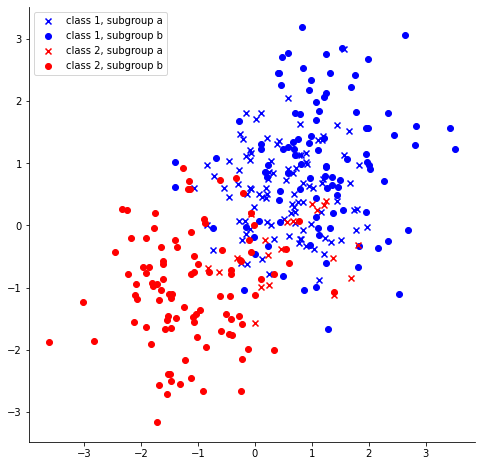

In [54]:
# Plot data
s1 = (X[:, 2] < 0)
s2 = (X[:, 2] > 0)

c1s1 = (y[s1] == -1)
c1s2 = (y[s2] == -1)
c2s1 = (y[s1] ==  1)
c2s2 = (y[s2] ==  1)


plt.figure(figsize=(8, 8))

plt.scatter(X[s1, 0][c1s1], X[s1, 1][c1s1], marker='x', color='b', label="class 1, subgroup a")
plt.scatter(X[s2, 0][c1s2], X[s2, 1][c1s2], marker='o', color='b', label="class 1, subgroup b")

plt.scatter(X[s1, 0][c2s1], X[s1, 1][c2s1], marker='x', color='r', label="class 2, subgroup a")
plt.scatter(X[s2, 0][c2s2], X[s2, 1][c2s2], marker='o', color='r', label="class 2, subgroup b")

plt.legend()
sns.despine()

**Questions:**
1. What differentiates subgroup a from subgroup b?
1. How a fair classification boundary should look?

### Train a vanila pytorch model

In [82]:
# data parameters
n_samples = 1000
n_samples_low = 200

# Prepare the dataset
X, y, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=0)
X_test, y_test, _,_,_ = generate_toy_data(n_samples, n_samples_low, n_dimensions=2, seed=1)

X = torch.tensor(X).float()
X_test = torch.tensor(X_test).float()

# Change labels from -1, 1 to 0, 1
y = torch.tensor(y)
y[y == -1] = 0

y_test = torch.tensor(y_test)
y_test[y_test == -1] = 0


data_train = torch.utils.data.TensorDataset(X, y)
loss       = torch.nn.CrossEntropyLoss(reduction='none')

In [83]:
# Params
num_epochs = 10
lr = 0.02
batch_size = 256

model = torch.nn.Sequential(
  torch.nn.Linear(3, 8),
  torch.nn.Sigmoid(),
  torch.nn.Linear(8, 2),
)

opt  = torch.optim.Adam(model.parameters(), lr=lr)
dl   = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)


for i in range(num_epochs):
  print("Training epoch", i)

  for x, y_t in dl:
    opt.zero_grad()

    y_hat  = model(x)
    losses = loss(y_hat, y_t)


    # Backpropagate and optimize    
    losses.mean().backward()
    opt.step()

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9


In [84]:
# Evaluate model

with torch.no_grad():
  y_hat = model(X_test)

y_class = y_hat.argmax(dim=1)


print("Number of missclassifications", (y_class != y_test).sum().item(), "out of", y_test.shape[0], "or", (y_class != y_test).sum().item() /  y_test.shape[0])

Number of missclassifications 303 out of 3200 or 0.0946875


In [85]:
y_mask  = (y_class != y_test)
x_group = X_test[:, 2][y_mask]

print("Number of missclassifications for subgroup a", (x_group < 0).sum().item(), "out of", y_test.shape[0], "or", (x_group < 0).sum().item() /  y_test.shape[0])
print("Number of missclassifications for subgroup b", (x_group > 0).sum().item(), "out of", y_test.shape[0], "or", (x_group > 0).sum().item() /  y_test.shape[0])

Number of missclassifications for subgroup a 181 out of 3200 or 0.0565625
Number of missclassifications for subgroup b 122 out of 3200 or 0.038125


**Questions:**
1. The subgroup attribute is part of the training data. Would the results change if we remove it?
1. How can we fix this and make the model more fair?
1. In this case we have two subgroups and want to be fair to both. But what if we want to be fair to each sample, how can we do that? 

## Definition and fainess metrics


### Notation:

To simplify things we will focus only on classification. Although, the methods work for both, regression and classification.


- $X$ - input ($x$ one input sample)
- $Y$ - labels ($y$ one label sample)
- $S$ - sensitive attributes which are part of X (e.g., gender, age, race)
- $f$ - model we train, i.e., $f(x; \theta)$ returns the probability of each labels
- $\theta$ - model parameters, e.g., the weights and the biases for NN
- $\ell$ - loss function, here we will always use cross-entropy ($-log f(x; \theta) [y]$)
- $\mathbb{E}[\ell(f, X, Y)]$ - loss value, i.e., average loss
- $\min\mathbb{E}[\ell(f, X, Y)]$ - optimization objective

### Definitions of perfect fairness



- *Demografic parity:* $S \perp f(X; \theta)$
- *Equaized odds:* $S \perp f(X; \theta) \mid Y$
- *Lack of disparate mistreatment:* $\mathbb{P}(f(X; \theta) \neq Y \mid S = s_a) = \mathbb{P}(f(X; \theta) \neq Y \mid S = s_b) , \forall s_a, s_b \in S$

**Questions:**
1. What is the difference between the first two from the perspective of application?
1. What is the problem with these definitions?

### Approximate fairness

- *Mean difference score:* $\max \mid \mathbb{P}(f(X; \theta) = y \mid S = s_a) - \mathbb{P}(f(X; \theta) = y \mid S = s_b) \mid, \forall s_a, s_b \in S, \forall y \in Y$

- *Covariance:* $\mathbb{E}[f(X; \theta) \cdot S] - \mathbb{E}[f(X; \theta)] \cdot \mathbb{E}[S]$

**Questions:**
1. Why these two metrics are approximate
1. Why we use the approximate metrics instead of perfect metrics of fairness?

[Correlation Wikipedia](https://en.wikipedia.org/wiki/Correlation)

## Conditional Value at Risk method (simplified)

**Idea:** what if we minimize each subgroup separately to match the accuracy of the other subgroups.

**Question:** How to do that?

Let:
- $L$ be $\mathbb{E}[\ell(f, X, Y)]$ be the average loss for each subgroup.
- $L_{s_a}$ be $\mathbb{E}[\ell(f, X, Y) \mid S = s_a]$ be the average loss for subgroup $s_a$.

**Then at each step optimize only subgroups that have $L_{s} > L$**

Let's see how we can code that.

In [243]:
# Params
num_epochs = 10
lr = 0.02
batch_size = 256

sensitive_idx=2

model = torch.nn.Sequential(
  torch.nn.Linear(3, 8),
  torch.nn.Sigmoid(),
  torch.nn.Linear(8, 2),
)


opt  = torch.optim.Adam(model.parameters(), lr=lr)
dl   = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)


for i in range(num_epochs):
  print("Training epoch", i)

  for x, y_t in dl:
    opt.zero_grad()

    y_hat  = model(x)
    losses = loss(y_hat, y_t)
    l_mean = losses.mean().detach()

    groups = x[:,sensitive_idx].unique()
    sum    = 0
    for c in groups:
      mask = (x[:,sensitive_idx] == c)
      sum += (losses[mask].mean() - l_mean).clip(0.0)

    (sum / groups.shape[0]).backward()

    opt.step()

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9


In [244]:
# Evaluate model

with torch.no_grad():
  y_hat = model(X_test)

y_class = y_hat.argmax(dim=1)


print("Number of missclassifications", (y_class != y_test).sum().item(), "out of", y_test.shape[0], "or", (y_class != y_test).sum().item() /  y_test.shape[0])

Number of missclassifications 365 out of 3200 or 0.1140625


In [245]:
y_mask  = (y_class != y_test)
x_group = X_test[:, 2][y_mask]

print("Number of missclassifications for subgroup a", (x_group < 0).sum().item(), "out of", y_test.shape[0], "or", (x_group < 0).sum().item() /  y_test.shape[0])
print("Number of missclassifications for subgroup b", (x_group > 0).sum().item(), "out of", y_test.shape[0], "or", (x_group > 0).sum().item() /  y_test.shape[0])

Number of missclassifications for subgroup a 173 out of 3200 or 0.0540625
Number of missclassifications for subgroup b 192 out of 3200 or 0.06


**Questions:**
- What do we observe?
- Why do we call `.detach()` on `l_mean`?
- Why do we clip to `0.0`?
- Can we control the fairness, i.e., put more weight on fairness property?
- By looking at the accuracy for each subgroup can you tell which one is which?
- Can we characterize more precisly the fairness amongst subgroups?

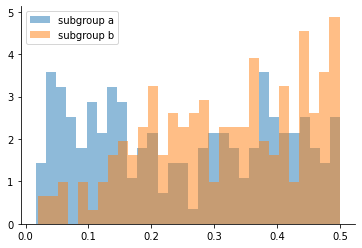

In [248]:
# Select predicted prob by subgroup
pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True, label="subgroup a")
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True, label="subgroup b")
plt.legend()
sns.despine()

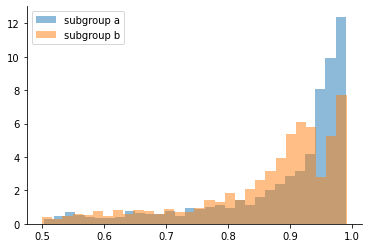

In [249]:
# Select predicted prob by subgroup
y_mask  = (y_class == y_test)
x_group = X_test[:, 2][y_mask]


pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True, label="subgroup a")
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True, label="subgroup b")
plt.legend()
sns.despine()

**Question:**
- Knowing the limitations, how can we further improve the method? (hint: from "on-off" to variable weight)

## Moments penalization

**What if at each step we set a weight to each subgroup based on how far $L_{s}$ is from $L$**



In [281]:
# Params
num_epochs = 10
lr = 0.02
batch_size = 256

lambda_1 = 1.0
lambda_2 = 5.0
lambda_3 = 0.0
sensitive_idx=2

model = torch.nn.Sequential(
  torch.nn.Linear(3, 8),
  torch.nn.Sigmoid(),
  torch.nn.Linear(8, 2),
)

opt  = torch.optim.Adam(model.parameters(), lr=lr)
dl   = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

logs = []

for i in range(num_epochs):
  for x, y_t in dl:
    opt.zero_grad()

    y_hat  = model(x)
    losses = loss(y_hat, y_t)

    z      = losses.detach()
    z_mean = z.mean()


    # Calculate mean loss for each class
    class_mean_loss = torch.zeros_like(z)
    lambda_2v       = lambda_2 * torch.ones_like(z)
    lambda_3v       = lambda_3 * torch.ones_like(z)


    for c in x[:,sensitive_idx].unique():
      mask = (x[:,sensitive_idx] == c)
      class_mean_loss[mask] = z[mask].mean()

    # Calculate weights
    w = lambda_1 + lambda_2v * (class_mean_loss - z_mean) / z_mean + \
        lambda_3v * (z - class_mean_loss - z.var()/z_mean)
    w = w.clip(0.0)

    # Backpropagate and optimize    
    (w * losses).mean().backward()
    opt.step()

In [277]:
# Evaluate model

with torch.no_grad():
  y_hat = model(X_test)

y_class = y_hat.argmax(dim=1)


print("Number of missclassifications", (y_class != y_test).sum().item(), "out of", y_test.shape[0], "or", (y_class != y_test).sum().item() /  y_test.shape[0])

Number of missclassifications 316 out of 3200 or 0.09875


In [278]:
y_mask  = (y_class != y_test)
x_group = X_test[:, 2][y_mask]

print("Number of missclassifications for subgroup a", (x_group < 0).sum().item(), "out of", y_test.shape[0], "or", (x_group < 0).sum().item() /  y_test.shape[0])
print("Number of missclassifications for subgroup b", (x_group > 0).sum().item(), "out of", y_test.shape[0], "or", (x_group > 0).sum().item() /  y_test.shape[0])

Number of missclassifications for subgroup a 168 out of 3200 or 0.0525
Number of missclassifications for subgroup b 148 out of 3200 or 0.04625


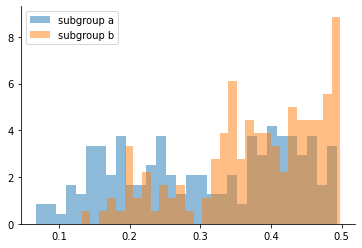

In [279]:
# Select predicted prob by subgroup
pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True, label="subgroup a")
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True, label="subgroup b")
plt.legend()
sns.despine()

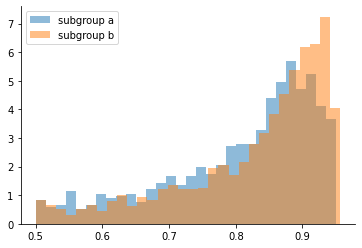

In [280]:
# Select predicted prob by subgroup
y_mask  = (y_class == y_test)
x_group = X_test[:, 2][y_mask]


pred_prob   = torch.tensor([y[idx].item() for y, idx in zip(y_hat.softmax(dim=1), y_test)])
pred_prob_a = pred_prob[y_mask][x_group < 0]
pred_prob_b = pred_prob[y_mask][x_group > 0]

plt.hist(pred_prob_a.numpy(), alpha=0.5, bins=30, density=True, label="subgroup a")
plt.hist(pred_prob_b.numpy(), alpha=0.5, bins=30, density=True, label="subgroup b")
plt.legend()
sns.despine()

**Questions:**
- Why do we use `z` variable instead of `losses` variable?
- How can we enforce subgroup fairness and individual fairness at the same time?
- Does it scale if we have more than 2 subgroups?


**What did we learn ("the take home" messages)?**

## Bonus Questions

- Why the last method is called moments penalization?
- What about the third moment?
- In settings with multiple subgroups, how can we even further enforce fairness? (hint: loss function)
- Why does the method also works for regression?

## References:
1. Michele Donini, et al. "Empirical Risk Minimization under Fairness Constraints." – the dataset
1. Robert Williamson, Aditya Menon "Fairness risk measures" – Conditional Value at Risk
1. 